In [1]:
import requests
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import json
from flatten_json import flatten

In [2]:
# # Plotting settings
# # %matplotlib notebook
# import mpld3
# mpld3.enable_notebook()
# %matplotlib notebook
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (15,5)

import mpld3
# mpld3.enable_notebook()
%matplotlib notebook
# %matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (15,5)


In [5]:
class farm_data():
    
    def __init__(self, sensor_id, start_date, end_date, max_items = '1000', auth_token = None):
        
        self.dev_id = sensor_id
        self.device_uid = 'device_uid='+self.dev_id+'&'
        self.date = 'start_date='+start_date+'&'+'end_date='+end_date
        self.limit = '&limit='+max_items
        self.base_url = 'http://pwrnet-158117.appspot.com/api/v1/farm_device_data/?'
        self.auth_token = 'adde8a3993d902769197c1db98a9ab0e88dce587'
        self.headers = {'Authorization': 'Token ' + self.auth_token}
        
    def get_data(self, url=None):
        # Check to see if id is valid
        # The first case should not be none - it should be the url -> maybe remove the url=None
        if url is None:
            try:
                resp = requests.get(self.base_url+self.device_uid+self.date+self.limit, headers=self.headers)
                resp.raise_for_status()
            except requests.exceptions.HTTPError as err:
                return None
        else:
            try:
                resp = requests.get(url, headers=self.headers)
                resp.raise_for_status()
            except requests.exceptions.HTTPError as err:
                return None
        
        data = resp.json()['results']
        if resp.json()['next'] is None:
            return data
        else:
            return (data+self.get_data(url=resp.json()['next']))
            
            
    def convert2pandas(self, raw_data):
        dev_id = int(self.dev_id)
        if raw_data is None:
            print('No data collected')
            return None
        # Checking for Lora sensors - need to automate this in case the number of lora devices grow (pull info from FarmDevice endpoint or check what type of sensr the id corresponds to)
        if dev_id < 17 and dev_id > 0:
            data_flat = [flatten(json.loads(d['device_data'])) for d in raw_data]
            return pd.DataFrame(data_flat)
        elif dev_id == 46613:
            data_flat = [flatten(json.loads(d['device_data'])) for d in raw_data]
            df = pd.DataFrame(data_flat)
            return df[df.columns[~df.columns.str.contains('raw_')]] # returning only processed data
        elif dev_id == 67682 or dev_id == 67670:
            data_flat = [flatten(d['device_data']) for d in raw_data]
            return pd.DataFrame(data_flat)  
        elif dev_id == 100000:
            df_list = []
            for d in raw_data:
                df_list.append(pd.DataFrame(d['device_data']))
            return pd.concat(df_list)
        else:
            print('No parsing available for this device ID')
            return None


# Cost Analysis

In [6]:
# Include demand charges in the calculations. Break down data into peak hours (12-6) and non-peak, resample for 15min interval and calculate the maximum power over that time period
# Input Variables
energy_pk_summer = 0.31752 # $/kWh
energy_opk_summer = 0.16888 # $/kWh
demand_max_summer = 10.77 # $/kW -> Maximum demand during billing cycle
demand_max_pk_summer = 5.79 # $/kW -> Maximum demand during pek hours for billing cycle
pk_hours_start = 12
pk_hours_end = 18



In [7]:
# Loading data:
egauge_object = farm_data('46613','2019-08-23', '2019-08-31', max_items = '1000')
egauge_data = egauge_object.get_data()
egauge_pd = egauge_object.convert2pandas(egauge_data)
# Processing
egauge_pd = egauge_pd[['processed_timestamp', 'processed_CONTROL_FAN_POWER', 'processed_CONTROL_FAN_POWER*', 'processed_POWER_TEST_PEN', 'processed_POWER_TEST_PEN*', 'processed_SHED_POWER', 'processed_POWER_CIRCUIT1', 'processed_POWER_CIRCUIT2','processed_L1 - VOLTAGE_C', 'processed_L2 - VOLTAGE_A']]
egauge_pd['processed_timestamp'] = pd.to_datetime(egauge_pd['processed_timestamp'], utc=True)
egauge_pd.set_index('processed_timestamp', inplace=True)
egauge_pd.index = egauge_pd.index.tz_convert('America/Los_Angeles')
egauge_pd = egauge_pd.sort_index()
egauge_pd['datetime'] = egauge_pd.index # creating datetime column
egauge_pd['date'] = egauge_pd['datetime'].dt.date # creating date column
egauge_pd['processed_POWER_CIRCUIT2'] = -egauge_pd['processed_POWER_CIRCUIT2']
egauge_pd['processed_POWER_CIRCUIT1'] = -egauge_pd['processed_POWER_CIRCUIT1']
egauge_pd['processed_SHED_POWER'] = -egauge_pd['processed_SHED_POWER']
egauge_pd['processed_CONTROL_FAN_POWER'] = -egauge_pd['processed_CONTROL_FAN_POWER']
# egauge_pd['processed_CONTROL_FAN_POWER*'] = -egauge_pd['processed_CONTROL_FAN_POWER*']
egauge_pd['processed_POWER_TEST_PEN'] = -egauge_pd['processed_POWER_TEST_PEN']
# egauge_pd['processed_POWER_TEST_PEN*'] = -egauge_pd['processed_POWER_TEST_PEN*']
egauge_pd['POWER_TEST_FANS'] = egauge_pd['processed_POWER_CIRCUIT1']+egauge_pd['processed_POWER_CIRCUIT2']
egauge_pd['POWER_TEST_PEN'] = egauge_pd['POWER_TEST_FANS'] + egauge_pd['processed_SHED_POWER']

/anaconda2/envs/venv_egauge/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/envs/venv_egauge/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


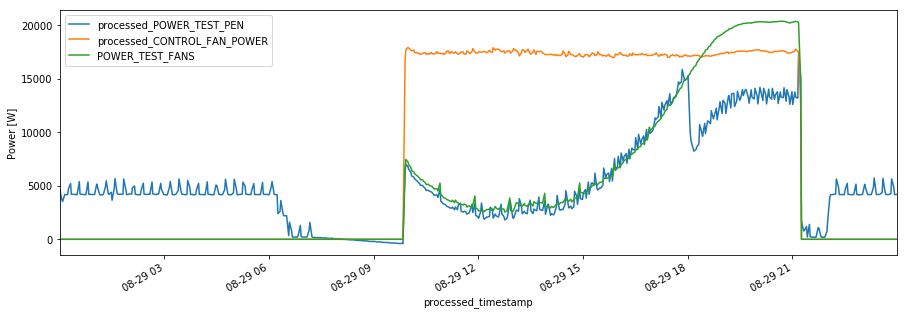

In [8]:
# Daily profiles
day = egauge_pd.loc[str(egauge_pd['date'].unique()[7])]
day['delta'] = (day['datetime']-day['datetime'].shift()).fillna(0)
# Real Power
ax = day.plot(y=['processed_POWER_TEST_PEN', 'processed_CONTROL_FAN_POWER', 'POWER_TEST_FANS'])
ax.set_ylabel('Power [W]')
plt.show()

In [10]:
# Resampling to 15 minute interval

test15min = day['processed_POWER_TEST_PEN'].resample('15min').mean() # Sampled at 5min
fans15min = day['POWER_TEST_FANS'].resample('15min').mean() # Sampled at 5min
control15min = day['processed_CONTROL_FAN_POWER'].resample('15min').mean() # Sampled at 5min

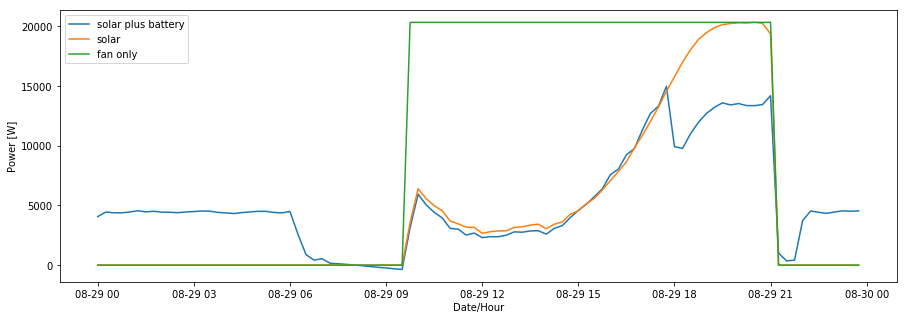

In [12]:
df_15min = pd.DataFrame()
df_15min['testPen'] = test15min
df_15min['testFans'] = fans15min
df_15min['controlPen'] = control15min
df_15min.index = df_15min.index.tz_localize(None)
# Creating Virtual Fan Load (without solar/battery -> based on maximum power)
df_15min['virtualFans'] = df_15min['controlPen']
df_15min.loc[df_15min['virtualFans'] > 3500, 'virtualFans'] = max(df_15min['testFans'])
# Finding dP
df_15min['dP'] = df_15min['controlPen'] - df_15min['controlPen'].shift(1)
df_15min['dP'].fillna(0, inplace=True)
# Finding max and min dP index
time_on = df_15min.loc[df_15min['dP'] == max(df_15min['dP'])]
time_off = df_15min.loc[df_15min['dP'] == min(df_15min['dP'])]
start = time_on.index.hour-1
stop = time_off.index.hour+1
# # Creating mask
# time_mask = (df_15min.index.hour >= start[0]) & (df_15min.index.hour < stop[0])
# # Final df
# df_day = df_15min[time_mask]
plt.plot(df_15min['testPen'], label='solar plus battery')
plt.plot(df_15min['testFans'], label='solar')
plt.plot(df_15min['virtualFans'], label='fan only')
plt.xlabel('Date/Hour')
plt.ylabel('Power [W]')
plt.legend()

plt.show()

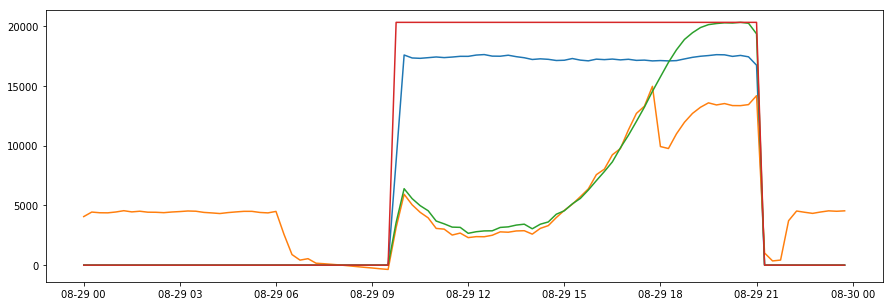

In [8]:
df_15min = pd.DataFrame()
df_15min['testPen'] = test15min
df_15min['testFans'] = fans15min
df_15min['controlPen'] = control15min
df_15min.index = df_15min.index.tz_localize(None)
# Creating Virtual Fan Load (without solar/battery -> based on maximum power)
df_15min['virtualFans'] = df_15min['controlPen']
df_15min.loc[df_15min['virtualFans'] > 3500, 'virtualFans'] = max(df_15min['testFans'])
# Finding dP
df_15min['dP'] = df_15min['controlPen'] - df_15min['controlPen'].shift(1)
df_15min['dP'].fillna(0, inplace=True)
# Finding max and min dP index
time_on = df_15min.loc[df_15min['dP'] == max(df_15min['dP'])]
time_off = df_15min.loc[df_15min['dP'] == min(df_15min['dP'])]
start = time_on.index.hour-1
stop = time_off.index.hour+1
# # Creating mask
# time_mask = (df_15min.index.hour >= start[0]) & (df_15min.index.hour < stop[0])
# # Final df
# df_day = df_15min[time_mask]
# plt.plot(df_15min['controlPen'])
plt.plot(df_15min['testPen'])
plt.plot(df_15min['testFans'])
plt.plot(df_15min['virtualFans'])

In [9]:
# cost analysis function: taking one day and spreading across the month
def cost_analysis_weekdays(df,span='daily'):
    # Cost values
    energy_pk_summer = 0.31752 # $/kWh
    energy_opk_summer = 0.16888 # $/kWh
    demand_max_summer = 10.77 # $/kW -> Maximum demand during billing cycle
    demand_max_pk_summer = 5.79 # $/kW -> Maximum demand during pek hours for billing cycle
    pk_hours_start = 12
    pk_hours_end = 18
    
    # energy and demand calculation:
    pk_hours_mask = (df_15min.index.hour >= pk_hours_start) & (df_15min.index.hour <= pk_hours_end)
    opk_hours_mask = ~pk_hours_mask
    energy = ((df[pk_hours_mask]*energy_pk_summer).sum() + (df[opk_hours_mask]*energy_opk_summer).sum())/4/1000 # /4 -> 15min interval, /1000 -> converting to kW
    if span != 'daily':
        energy = energy*22 # number of weekdays in a month
    demand = (df[pk_hours_mask].max()*demand_max_pk_summer +df.max()*demand_max_summer)/1000
    print('Energy Component: ', energy)
    print('Demand Component: ', demand)
    print('Total Weekday: ', energy+demand)
    return np.array([energy, demand])

def cost_analysis_weekends(df, span='daily'):
    # Assuming Max Demand happens in weekdays
    # Cost values
    energy_opk_summer = 0.16888 # $/kWh
    
    # energy calculation:
    pk_hours_mask = (df_15min.index.hour >= pk_hours_start) & (df_15min.index.hour <= pk_hours_end)
    opk_hours_mask = ~pk_hours_mask
    energy = ((df*energy_opk_summer).sum())/4/1000 # /4 -> 15min interval, /1000 -> converting to kW
    if span != 'daily':
        energy = energy*8
    print('Total Energy Weekend: ', energy)
    return energy

In [10]:
# Assuming this day incurs both demand charges for the month
print('COST FOR CONTROL PEN')
controlPen_cost_wkday = cost_analysis_weekdays(df_15min['controlPen'], span='daily')
controlPen_cost_wkend = cost_analysis_weekends(df_15min['controlPen'], span='daily')
print()
print('COST FOR TEST FANS')
virtual_cost_wkday = cost_analysis_weekdays(df_15min['virtualFans'], span='daily')
virtual_cost_wkend = cost_analysis_weekends(df_15min['virtualFans'], span='daily')
print()
print('COST FOR TEST FANS WITH SOLAR')
solar_cost_wkday = cost_analysis_weekdays(df_15min['testFans'], span='daily')
solar_cost_wkend = cost_analysis_weekends(df_15min['testFans'], span='daily')
print()
print('COST FOR TEST FANS WITH SOLAR + BATTERY')
solarbatt_cost_wkday = cost_analysis_weekdays(df_15min['testPen'], span='daily')
solarbatt_cost_wkend = cost_analysis_weekends(df_15min['testPen'], span='daily')

COST FOR CONTROL PEN
Energy Component:  51.280366753333325
Demand Component:  291.94452
Total Weekday:  343.22488675333335
Total Energy Weekend:  33.30140498

COST FOR TEST FANS
Energy Component:  60.62898898666669
Demand Component:  336.62616
Total Weekday:  397.2551489866667
Total Energy Weekend:  39.478458373333325

COST FOR TEST FANS WITH SOLAR
Energy Component:  26.224557606666668
Demand Component:  328.33391500000005
Total Weekday:  354.5584726066667
Total Energy Weekend:  18.273463373333332

COST FOR TEST FANS WITH SOLAR + BATTERY
Energy Component:  27.606333006666667
Demand Component:  247.90872
Total Weekday:  275.5150530066667
Total Energy Weekend:  20.725192846666666


In [11]:
# Monthly Cost per pen configuration:
print('COST FOR CONTROL PEN')
controlPen_cost_wkday = cost_analysis_weekdays(df_15min['controlPen'], 'monthly')
controlPen_cost_wkend = cost_analysis_weekends(df_15min['controlPen'], 'monthly')
controlPen_TotalCost = controlPen_cost_wkday.sum()+controlPen_cost_wkend
print('CONTROL PEN MONTHLY COST: ', controlPen_cost_wkday.sum()+controlPen_cost_wkend)
print()

print('COST FOR TEST FANS')
virtual_cost_wkday = cost_analysis_weekdays(df_15min['virtualFans'], 'monthly')
virtual_cost_wkend = cost_analysis_weekends(df_15min['virtualFans'], 'monthly')
virtualTestPen_TotalCost = virtual_cost_wkday.sum()+virtual_cost_wkend
print('TEST FANS MONTHLY COST: ', virtual_cost_wkday.sum()+virtual_cost_wkend)
print()

print('COST FOR TEST FANS WITH SOLAR')
solar_cost_wkday = cost_analysis_weekdays(df_15min['testFans'], 'monthly')
solar_cost_wkend = cost_analysis_weekends(df_15min['testFans'], 'monthly')
BlenderTestPen_TotalCost = solar_cost_wkday.sum()+solar_cost_wkend
print('TEST FANS WITH SOLAR MONTHLY COST: ', solar_cost_wkday.sum()+solar_cost_wkend)
print()

print('COST FOR TEST FANS WITH SOLAR + BATTERY')
solarbatt_cost_wkday = cost_analysis_weekdays(df_15min['testPen'], 'monthly')
solarbatt_cost_wkend = cost_analysis_weekends(df_15min['testPen'], 'monthly')
BlenderBattTestPen_TotalCost = solarbatt_cost_wkday.sum()+solarbatt_cost_wkend
print('TEST FANS WITH SOLAR + BATTERY MONTHLY COST: ', solarbatt_cost_wkday.sum()+solarbatt_cost_wkend)

COST FOR CONTROL PEN
Energy Component:  1128.1680685733331
Demand Component:  291.94452
Total Weekday:  1420.1125885733331
Total Energy Weekend:  266.41123984
CONTROL PEN MONTHLY COST:  1686.5238284133331

COST FOR TEST FANS
Energy Component:  1333.8377577066672
Demand Component:  336.62616
Total Weekday:  1670.4639177066672
Total Energy Weekend:  315.8276669866666
TEST FANS MONTHLY COST:  1986.2915846933338

COST FOR TEST FANS WITH SOLAR
Energy Component:  576.9402673466667
Demand Component:  328.33391500000005
Total Weekday:  905.2741823466667
Total Energy Weekend:  146.18770698666665
TEST FANS WITH SOLAR MONTHLY COST:  1051.4618893333334

COST FOR TEST FANS WITH SOLAR + BATTERY
Energy Component:  607.3393261466666
Demand Component:  247.90872
Total Weekday:  855.2480461466666
Total Energy Weekend:  165.80154277333332
TEST FANS WITH SOLAR + BATTERY MONTHLY COST:  1021.0495889199999


In [12]:
# 12 barns with 2 pens each
print('BARN CONTROL MONTHLY COST: ', controlPen_TotalCost*12*2)
print('BARN TEST FANS MONTHLY COST: ', virtualTestPen_TotalCost*12*2)
print('BARN TEST FANS WITH SOLAR MONTHLY COST: ', BlenderTestPen_TotalCost*12*2)
print('BARN TEST FANS WITH SOLAR + BATTERY MONTHLY COST: ', BlenderBattTestPen_TotalCost*12*2)

BARN CONTROL MONTHLY COST:  40476.57188192
BARN TEST FANS MONTHLY COST:  47670.99803264001
BARN TEST FANS WITH SOLAR MONTHLY COST:  25235.085344
BARN TEST FANS WITH SOLAR + BATTERY MONTHLY COST:  24505.190134079996


In [2]:
(1986-1021)/1986

0.48590130916414903

In [83]:
farm_bill = pd.read_csv('DD_Bill.csv')

In [84]:
farm_bill['Date'] = pd.to_datetime(farm_bill['Date'], utc=True).dt.strftime('%Y/%m')
farm_bill.sort_values(by='Date',inplace=True)
farm_bill.set_index('Date', inplace=True)

In [85]:
farm_bill.head(10)

,Date,Cost($)
32,2016/01,10677.36
31,2016/02,11759.22
30,2016/03,13494.26
29,2016/04,12348.06
28,2016/05,16624.76
27,2016/06,31481.05
26,2016/07,34647.10
25,2016/08,40247.26
24,2016/09,32932.31
23,2016/10,26468.05


<IPython.core.display.Javascript object>


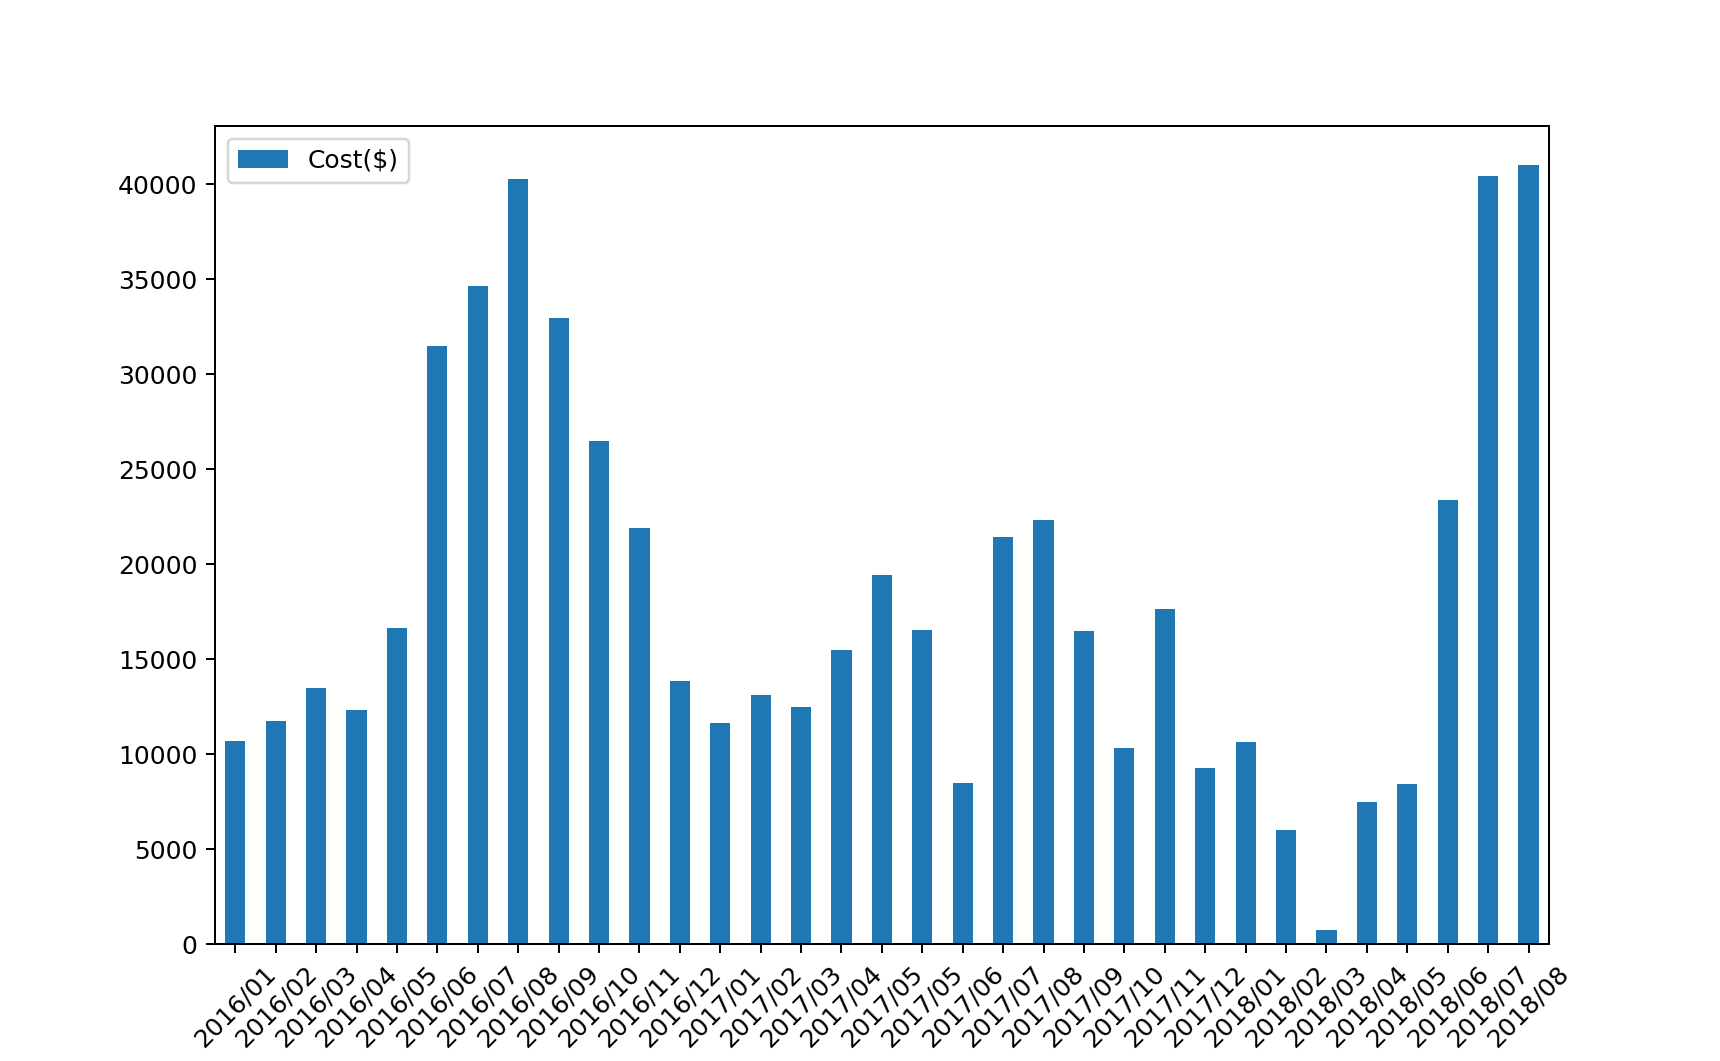

In [126]:
farm_bill.plot.bar(rot=45)

In [116]:
df = pd.read_csv('DD_Demand.csv')


In [117]:
df.head()

,Date,On-Peak Demand (kW),Part-Peak Demand (kW),Off-Peak Demand (kW)
0,8/1/18,665,0,682
1,7/1/18,707,0,680
2,6/1/18,676,0,665
3,5/1/18,665,658,666
4,4/1/18,0,669,675


In [118]:
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.strftime('%Y/%m')
df.sort_values(by='Date',inplace=True)
df.set_index('Date', inplace=True)

In [119]:
df.index

Index(['2016/01', '2016/02', '2016/03', '2016/04', '2016/05', '2016/06',
       '2016/07', '2016/08', '2016/09', '2016/10', '2016/11', '2016/12',
       '2017/01', '2017/02', '2017/03', '2017/04', '2017/05', '2017/06',
       '2017/07', '2017/08', '2017/09', '2017/10', '2017/11', '2017/12',
       '2018/01', '2018/02', '2018/03', '2018/04', '2018/05', '2018/06',
       '2018/07', '2018/08'],
      dtype='object', name='Date')

<IPython.core.display.Javascript object>


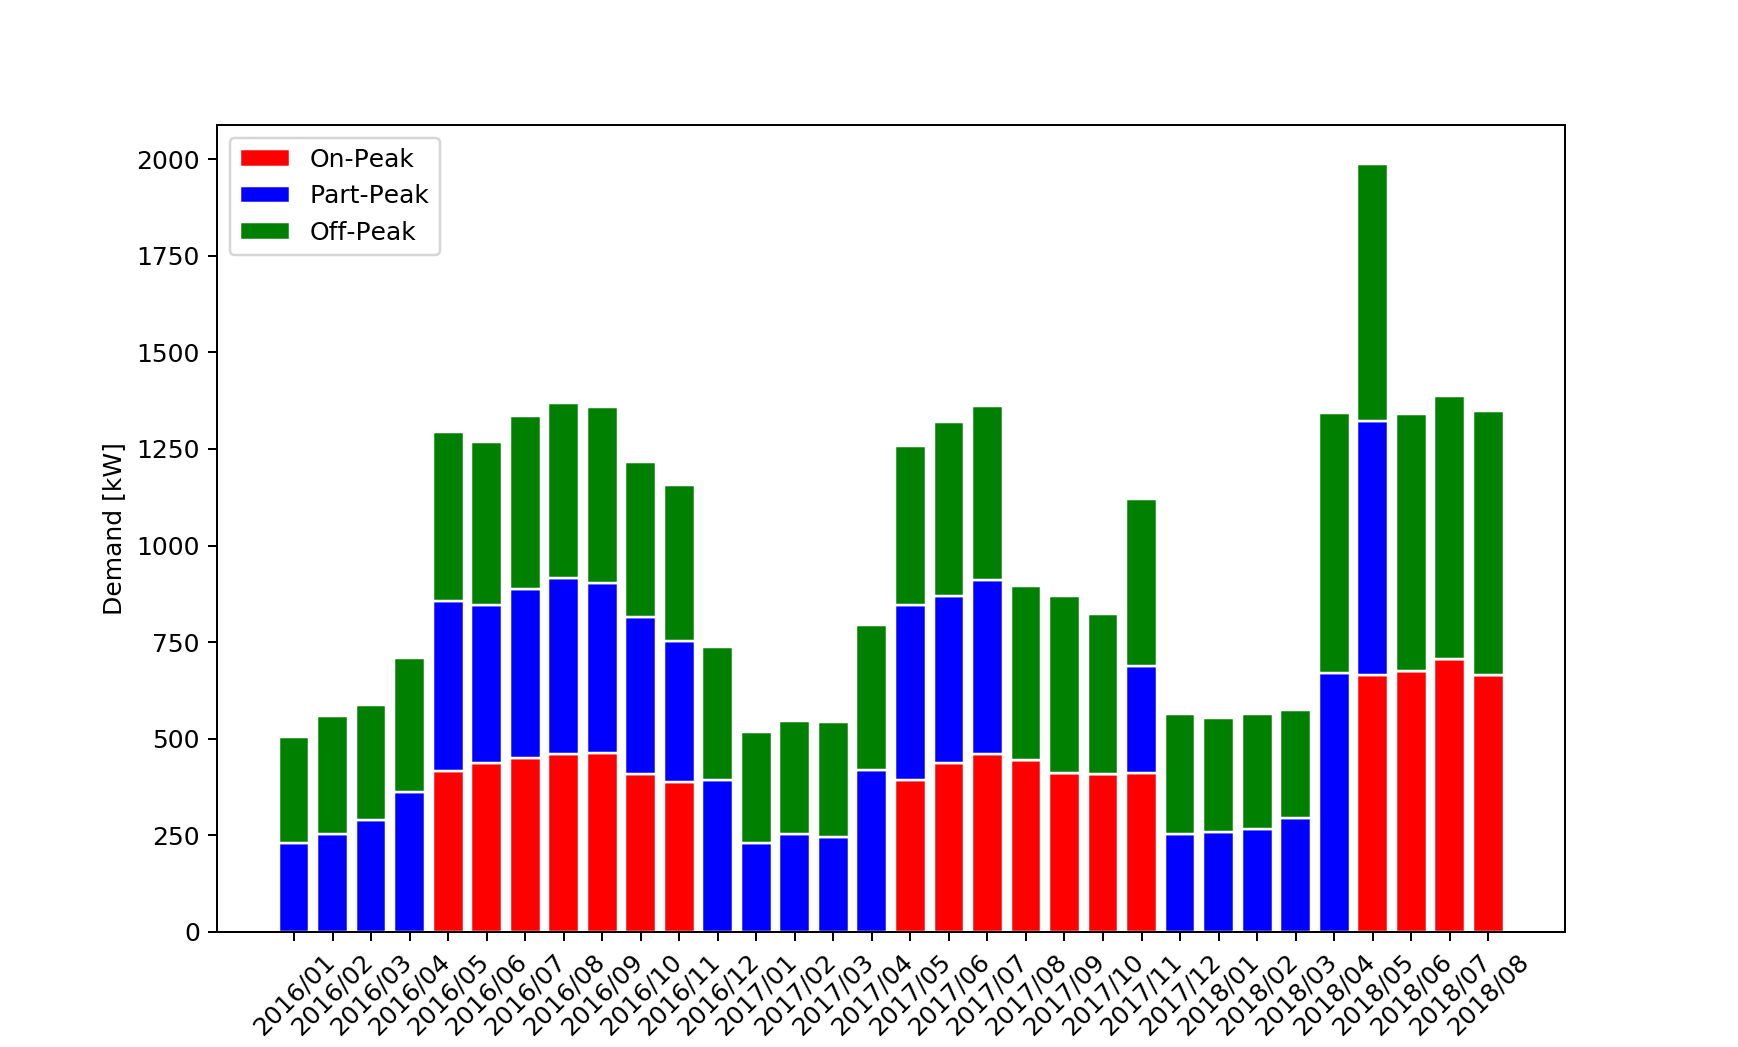

In [125]:
onpk = df['On-Peak Demand (kW)']
partpk = df['Part-Peak Demand (kW)']
offpk = df['Off-Peak Demand (kW)']
x_axis = df.index
plt.bar(x_axis, onpk, color='red',edgecolor='white', label='On-Peak')
plt.bar(x_axis, partpk, bottom=onpk, color='blue', edgecolor='white', label='Part-Peak')
plt.bar(x_axis, offpk, bottom=onpk+partpk, color='green', edgecolor='white', label='Off-Peak')
plt.xticks(rotation=45)
plt.xlabel('Year/Month')
plt.ylabel('Demand [kW]')
plt.legend()